# Notebook EDA del Titanic con datos de Kaggle

# Celda 1 ‚Äî Imports y ajustes:
Configuraci√≥n inicial: Imports y ajustes
Utilidades (guardar im√°genes/tablas; no toca README)

In [1]:
# Celda 1 ‚Äî Imports y ajustes:
# Utilidades (guardar im√°genes/tablas; no toca README)
# Importar librer√≠as necesarias

%matplotlib inline

from pathlib import Path                 # Manejo de rutas y carpetas
import matplotlib.pyplot as plt          # Gr√°ficos base (Matplotlib)
import pandas as pd                      # DataFrames
import numpy as np                       # C√°lculo num√©rico (percentiles, etc.)
import warnings; warnings.filterwarnings("ignore")
import seaborn as sns
from pathlib import Path
from scipy import stats
from sklearn.impute import SimpleImputer
sns.set_theme()

# Se guardan los PNG generados de gr√°ficos y tablas en la carpeta figures/
# Las im√°genes se sobrescriben de una ejecuci√≥n a otra
# Las im√°genes las podremos presentar en el propio README.md llamando desde el mismo a la referencia al figures/<name>.png

FIG_DIR = Path("figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)


def savefig(name, dpi=150, tight=True):
    """Guarda la figura actual en figures/<name>.png (sobrescribe)."""
    out = FIG_DIR / f"{name}.png"
    if tight:
        plt.savefig(out, dpi=dpi, bbox_inches='tight')
    else:
        plt.savefig(out, dpi=dpi)
    print('Guardado:', out)

def save_table_image(df_or_series, name: str, title: str | None = None,
                     fontsize: int = 10, col_width: float = 2.2,
                     row_height: float = 0.6, max_rows: int | None = 30,
                     round_ndigits: int | None = 2):
    """Renderiza un DataFrame/Series como PNG en figures/<name>.png (sobrescribe)."""
    if isinstance(df_or_series, pd.Series):
        df = df_or_series.to_frame()
    else:
        df = df_or_series.copy()
    if round_ndigits is not None:
        for c in df.select_dtypes(include=[np.number]).columns:
            df[c] = df[c].round(round_ndigits)
    df.index = df.index.map(str)
    df.columns = df.columns.map(str)
    overflow_note = ''
    if max_rows is not None and len(df) > max_rows:
        df = df.iloc[:max_rows, :]
        overflow_note = f' (truncado a {max_rows} filas)'
    n_rows, n_cols = df.shape
    fig_w = max(6, col_width * (n_cols + 1))
    fig_h = max(2.5, row_height * (n_rows + 2))
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    ax.axis('off')
    if title:
        ax.set_title(title + overflow_note, fontsize=fontsize+2, pad=10)
    table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index,
                     cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(fontsize)
    table.scale(1.0, 1.2)
    out_path = FIG_DIR / f"{name}.png"
    plt.savefig(out_path, dpi=200, bbox_inches='tight')
    plt.close(fig)
    print('Tabla guardada:', out_path)

# FASE 1 Exploraci√≥n incial: Reconocimiento del Dataset
Carga 891 pasajeros, 15 caracter√≠sticas
Identifica tipos: num√©ricos vs categ√≥ricos vs texto

## Celda 2 ‚Äî cargar Kaggle CSV (normalizamos nombres)

**Estructura del dataset:**

Conocer la estructura del conjunto de datos, los tipos de variables y obtener un primer vistazo de estos, es esencial para identificar posibles problemas y tomar decisiones informadas sobre c√≥mo proceder con el an√°lisis. 

La estructura del dataset se refiere a c√≥mo est√°n organizados los datos y su formato general. Al comprender la estructura, podemos saber qu√© esperar de ellos y c√≥mo acceder a la informaci√≥n necesaria.

**- Filas y columnas:** Es importante verificar cu√°ntas filas (registros) y columnas (caracter√≠sticas) contiene el conjunto de datos. Esto se puede hacer con la funci√≥n df.shape en Pandas.
**- Nombres de las columnas:** Identificar los nombres de las columnas es clave para saber qu√© variables se est√°n analizando. Se puede visualizar con df.columns.
**- Tama√±o y dimensiones:** Si los datos son grandes, es √∫til comprobar las primeras filas o una muestra aleatoria para conocer la "dimensi√≥n" de los datos sin sobrecargar la memoria. Se puede usar df.head() o df.sample().
**- Tipo de archivo:** El dataset puede estar en varios formatos, como CSV, Excel, JSON, SQL, etc. Es importante saber c√≥mo leerlo y cargarlo correctamente dependiendo de su formato.

**Tipos de Datos o variabes:**

**- Datos Num√©ricos:**			(datos que podemos medir)
 **‚Ä¢	Continuos:** Pueden tomar cualquier valor en un rango (altura, peso, temperatura)
 **‚Ä¢	Discretos:** Valores enteros espec√≠ficos (n√∫mero de hijos, cantidad de productos)

**Tratamiento en EDA:**
‚Ä¢	Estad√≠sticas descriptivas (media, mediana, desviaci√≥n est√°ndar)
‚Ä¢	Histogramas, boxplots, gr√°ficos de densidad
‚Ä¢	An√°lisis de distribuci√≥n y detecci√≥n de outliers


**- Datos Categ√≥ricos:	(datos con etiquetas, clasificaci√≥n)
  **‚Ä¢	Nominales:** Sin orden inherente (color, g√©nero, pa√≠s)
  **‚Ä¢	Ordinales:** Con orden espec√≠fico o l√≥gico (educaci√≥n: primaria < secundaria < universitaria)

**Tratamiento en EDA:**
‚Ä¢	Tablas de frecuencia y porcentajes
‚Ä¢	Gr√°ficos de barras, pie charts
‚Ä¢	An√°lisis de moda y distribuci√≥n de categor√≠as

**- Datos Temporales:**
  **‚Ä¢	Fechas, timestamps, series de tiempo**

Tratamiento en EDA:
‚Ä¢	An√°lisis de tendencias temporales
‚Ä¢	Estacionalidad y patrones c√≠clicos
‚Ä¢	Gr√°ficos de l√≠neas temporales

Consideraciones especiales del tratamiento de datos en EDA:
**‚Ä¢	Datos categ√≥ricos:** S√≥lo se puede calcular la moda como medida de tendencia central
**‚Ä¢	Datos ordinales:** Permiten c√°lculos de mediana y percentiles, pero no operaciones aritm√©ticas complejas
**‚Ä¢	Datos num√©ricos:** Permiten todas las operaciones estad√≠sticas y visualizaciones



**Primer Vistazo a los Datos**

Un primer vistazo a los datos nos permite verificar la calidad de la informaci√≥n y detectar posibles problemas. Aqu√≠ algunos pasos iniciales a realizar:

**‚Ä¢	Revisi√≥n de las primeras filas:** Obtener un resumen r√°pido de los primeros registros del dataset usando **df.head()**. Esto muestra las primeras filas y ayuda a detectar posibles problemas como datos mal ingresados.


In [2]:
# === Celda 2: Carga Kaggle, normaliza nombres y guarda tablas/im√°genes al README ===

# Celda 2 ‚Äî Carga de datos desde Kaggle y normalizaci√≥n
train = pd.read_csv("data/train.csv")

cols_map = {
    "Survived": "survived",
    "Pclass":   "pclass",
    "Sex":      "sex",
    "Age":      "age",
    "SibSp":    "sibsp",
    "Parch":    "parch",
    "Fare":     "fare",
    "Embarked": "embarked",
}
existing = [c for c in cols_map if c in train.columns]
df = train[existing].rename(columns=cols_map)

# Tipos recomendados
if "survived" in df.columns: df["survived"] = df["survived"].astype(int)
if "sex" in df.columns: df["sex"] = df["sex"].astype("category")
if "embarked" in df.columns: df["embarked"] = df["embarked"].astype("category")

# Primeras filas del dataset
display(df.head()); print("Shape:", df.shape); print(df.dtypes)

# Guardar im√°genes de tablas
save_table_image(df.head(), "tbl_head_raw", title="Head (raw normalizado)", round_ndigits=None)
dtypes_tbl = df.dtypes.astype(str).to_frame("dtype")
save_table_image(dtypes_tbl, "tbl_dtypes", title="Tipos de datos", round_ndigits=None)
shape_tbl = pd.DataFrame({"value":[df.shape[0], df.shape[1]]}, index=["rows","cols"])
save_table_image(shape_tbl, "tbl_shape", title="Shape del DataFrame", round_ndigits=None)


survived  pclass     sex   age  sibsp  parch     fare embarked
0         0       3    male  22.0      1      0   7.2500        S
1         1       1  female  38.0      1      0  71.2833        C
2         1       3  female  26.0      0      0   7.9250        S
3         1       1  female  35.0      1      0  53.1000        S
4         0       3    male  35.0      0      0   8.0500        S

Shape: (891, 8)
survived       int64
pclass         int64
sex         category
age          float64
sibsp          int64
parch          int64
fare         float64
embarked    category
dtype: object
Tabla guardada: figures\tbl_head_raw.png
Tabla guardada: figures\tbl_dtypes.png
Tabla guardada: figures\tbl_shape.png


# FASE 2 Evaluaci√≥n de la calidad:
Detecta: age (177 nulos), cabin (687 nulos), embarked (2 nulos) Estad√≠sticas: 38% supervivencia, edades 0.42-80 a√±os, tarifas 0-512¬£


# Celda 3 ‚Äî Inspecci√≥n y diagn√≥stico

**‚Ä¢	Revisi√≥n de tipos de datos:** Verificar que los tipos de datos de cada columna sean correctos (por ejemplo, asegurarse de que las fechas est√©n en formato de fecha). Se puede hacer con **df.dtypes**.
**‚Ä¢	Valores faltantes o nulos:** Identificar columnas con valores faltantes usando **df.isnull().sum()**, **df.isna().sum()**. Esto puede ayudar a identificar si es necesario imputar o eliminar datos.
**‚Ä¢	Estad√≠sticas descriptivas b√°sicas:** Obtener un resumen de las estad√≠sticas b√°sicas (media, mediana, desviaci√≥n est√°ndar, etc.) con **df.describe()**. Esto es √∫til para detectar anomal√≠as o valores at√≠picos de forma temprana.


In [3]:
# === Celda 3: Inspecci√≥n inicial + guardar tablas + actualizar README ===

# Informaci√≥n sobre tipos de datos y valores nulos por columna
nulls = df.isna().sum().sort_values(ascending=False)
display(nulls)
save_table_image(nulls, "tbl_nulls", title="Valores nulos por columna", round_ndigits=None)

# Estad√≠sticas descriptivas b√°sicas
desc_num = df.describe()
display(desc_num)
save_table_image(desc_num, "tbl_desc_num", title="Estad√≠sticas (num√©ricas)")

# Verificar dimensiones del dataset
print(f"El dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas")

cat_cols = df.select_dtypes(include=["object","category"]).columns
if len(cat_cols):
    desc_cat = df[cat_cols].describe().T
    display(desc_cat)
    save_table_image(desc_cat, "tbl_desc_cat", title="Estad√≠sticas (categ√≥ricas)", round_ndigits=None)

    cardinal = df[cat_cols].nunique().sort_values(ascending=False).to_frame("nunique")
    display(cardinal)
    save_table_image(cardinal, "tbl_cardinality", title="Cardinalidad de categ√≥ricas", round_ndigits=None)
else:
    print("(No hay columnas categ√≥ricas)")

age         177
embarked      2
pclass        0
survived      0
sex           0
sibsp         0
parch         0
fare          0
dtype: int64

Tabla guardada: figures\tbl_nulls.png


survived      pclass         age       sibsp       parch        fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std      0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   20.125000    0.000000    0.000000    7.910400
50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%      1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200

Tabla guardada: figures\tbl_desc_num.png
El dataset tiene 891 filas y 8 columnas


count unique   top freq
sex        891      2  male  577
embarked   889      3     S  644

Tabla guardada: figures\tbl_desc_cat.png


nunique
embarked        3
sex             2

Tabla guardada: figures\tbl_cardinality.png


# FASE 3: Limpieza (Celda 4 a Celda 6)

# Celda 4 ‚Äî limpieza (duplicados, imputaci√≥n, feature)
Imputa age con mediana (m√°s robusta que media) Imputa embarked con moda Crea family_size = siblings + parents + 1

In [4]:
# Celda 4 ‚Äî Limpieza: duplicados, imputaci√≥n, feature engineering

before = len(df)
df = df.drop_duplicates()
print("Duplicados eliminados:", before - len(df))

if "age" in df.columns:
    df["age"] = SimpleImputer(strategy="median").fit_transform(df[["age"]]).ravel()

if "embarked" in df.columns:
    df["embarked"] = df["embarked"].astype(object)
    df["embarked"] = SimpleImputer(strategy="most_frequent").fit_transform(df[["embarked"]]).ravel()
    df["embarked"] = df["embarked"].astype("category")

if {"sibsp","parch"}.issubset(df.columns):
    df[["sibsp","parch"]] = df[["sibsp","parch"]].fillna(0)
    df["sibsp"] = df["sibsp"].astype(int)
    df["parch"] = df["parch"].astype(int)
    df["family_size"] = df["sibsp"] + df["parch"] + 1

cols_verif = [c for c in ["age","embarked"] if c in df.columns]
nulls_post = df[cols_verif].isna().sum() if cols_verif else pd.Series(dtype="int64")
display(nulls_post)

save_table_image(df.head(), "tbl_head_post_clean", title="Head tras limpieza", round_ndigits=None)
if len(nulls_post):
    save_table_image(nulls_post, "tbl_nulls_post", title="Nulos tras imputaci√≥n", round_ndigits=None)




Duplicados eliminados: 111


age         0
embarked    0
dtype: int64

Tabla guardada: figures\tbl_head_post_clean.png
Tabla guardada: figures\tbl_nulls_post.png


# Celda 5: An√°lisis Univariado (hist edad + conteos survived) 

**An√°lisis Univariado:**

El **an√°lisis univariado** es el primer paso en la exploraci√≥n de datos y se centra en examinar cada variable individualmente. Su objetivo es comprender la distribuci√≥n, tendencia central y dispersi√≥n de los datos, adem√°s de identificar posibles valores at√≠picos.

**- Distribuci√≥n de Variables Individuales:**

El an√°lisis de la distribuci√≥n de una variable ayuda a entender c√≥mo se comportan los datos y si siguen una forma espec√≠fica, como una distribuci√≥n normal, uniforme o sesgada. Algunas t√©cnicas clave incluyen:

**‚Ä¢	Histogramas:** Muestran la frecuencia de los valores en intervalos espec√≠ficos, proporcionando una visi√≥n general de la forma de la distribuci√≥n. Se pueden generar con **matplotlib.hist()** o **seaborn.histplot()**.

**‚Ä¢	Gr√°ficos de densidad (KDE):** Una alternativa m√°s suave a los histogramas que usa funciones de estimaci√≥n de densidad de kernel para visualizar la distribuci√≥n (**seaborn.kdeplot()**).

**‚Ä¢	Boxplots:** Ayudan a identificar la mediana, cuartiles y valores at√≠picos de la distribuci√≥n de una variable (**seaborn.boxplot()**).

**- Medidas de Tendencia Central y Dispersi√≥n:**

Las estad√≠sticas descriptivas permiten resumir los datos y entender su comportamiento general. Entre las m√°s importantes est√°n:

**- Medidas de tendencia central:**
        Media ((\mu)): Promedio de los valores de la variable.
        Mediana: Valor central cuando los datos est√°n ordenados, √∫til para distribuciones sesgadas.
        Moda: Valor m√°s frecuente en la distribuci√≥n.

**- Medidas de dispersi√≥n:**
        Varianza ((\sigma^2)): Indica qu√© tan dispersos est√°n los datos respecto a la media.
        Desviaci√≥n est√°ndar ((\sigma)): Ra√≠z cuadrada de la varianza, mide la dispersi√≥n en las mismas unidades que los datos.
        Rango intercuart√≠lico (IQR): Diferencia entre el tercer y el primer cuartil ((Q3 - Q1)), √∫til para detectar outliers.


**- Identificaci√≥n de Outliers**

Los valores at√≠picos pueden distorsionar el an√°lisis y afectar la precisi√≥n de los modelos. Algunas t√©cnicas para detectarlos incluyen:

**‚Ä¢	M√©todo del rango intercuart√≠lico (IQR)**
        Se consideran outliers los valores que est√°n por debajo de (Q1 - 1.5 \times IQR) o por encima de (Q3 + 1.5 \times IQR).
        Se pueden visualizar con boxplots.

**‚Ä¢	Z-score (puntaje Z)**
        Mide cu√°ntas desviaciones est√°ndar se aleja un dato de la media.
        Se usa el criterio de valores absolutos mayores a 3 para identificar outliers.

**‚Ä¢	Gr√°ficos de dispersi√≥n (scatter plots)**
        Permiten observar puntos an√≥malos en distribuciones num√©ricas.



Guardado: figures\plot_hist_age.png


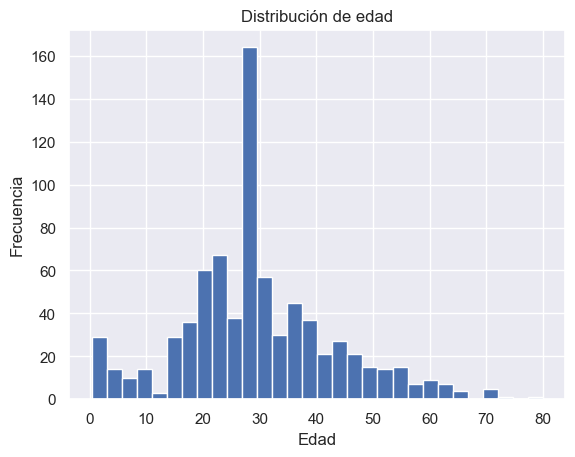

Guardado: figures\plot_count_survived.png


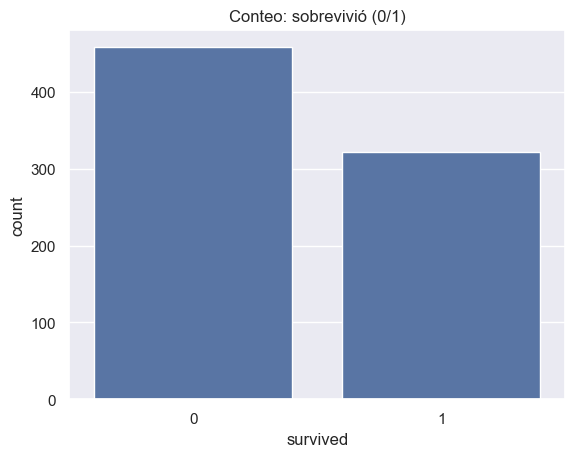

Tabla guardada: figures\tbl_survived_counts.png


In [5]:
# === Celda 5: Univariado (hist age + conteo survived) ==

imgs = []

if "age" in df.columns:
    plt.figure()
    df["age"].dropna().plot(kind="hist", bins=30)
    plt.title("Distribuci√≥n de edad"); plt.xlabel("Edad"); plt.ylabel("Frecuencia")
    savefig("plot_hist_age")
    plt.show()

if "survived" in df.columns:
    plt.figure()
    sns.countplot(x="survived", data=df)
    plt.title("Conteo: sobrevivi√≥ (0/1)")
    savefig("plot_count_survived")
    plt.show()

    vc = df["survived"].value_counts().rename_axis("survived").to_frame("count")
    save_table_image(vc, "tbl_survived_counts", title="Conteo survived (0/1)", round_ndigits=None)




### plot_hist_age.png
```bash
**Qu√© es:** Histograma de distribuci√≥n de edades
**Qu√© muestra:** Pico en 20-30 a√±os, pocos ni√±os y ancianos
**Insight:** Mayor√≠a pasajeros eran j√≥venes adultos
```

### plot_count_survived.png
```bash
**Qu√© es:** Gr√°fico de barras de supervivencia
**Qu√© muestra:** 549 muertos vs 342 vivos (38% supervivencia)
**Insight:** Mayor√≠a de pasajeros muri√≥ en el desastre
```

# Celda 6: An√°lisis Bivariado

**An√°lisis Bivariado y Multivariado**

El **an√°lisis bivariado y multivariado** se centra en estudiar las relaciones entre dos o m√°s variables dentro de un conjunto de datos. Mientras que el an√°lisis bivariado examina la relaci√≥n entre dos variables, el an√°lisis multivariado permite comprender interacciones m√°s complejas entre m√∫ltiples variables.
5.1. Relaciones entre Variables

El primer paso en el an√°lisis bivariado y multivariado es determinar si existe una relaci√≥n entre las variables y qu√© tipo de relaci√≥n presentan:

**‚Ä¢	Relaciones entre variables num√©ricas**
        Gr√°ficos de dispersi√≥n (scatter plots): √ötiles para visualizar relaciones lineales o no lineales.
        Diagramas de hexbin o pair plots con **seaborn.pairplot()** para detectar patrones.

**‚Ä¢	Relaciones entre una variable categ√≥rica y una num√©rica**
        Boxplots y violin plots: Comparan la distribuci√≥n de una variable num√©rica dentro de diferentes categor√≠as.
        Diagramas de barras (bar plots): Comparan promedios o medianas entre grupos.

**‚Ä¢	Relaciones entre variables categ√≥ricas**
        Tablas de contingencia y gr√°ficos de barras apiladas para visualizar distribuciones conjuntas.


Guardado: figures\plot_box_fare_survived.png


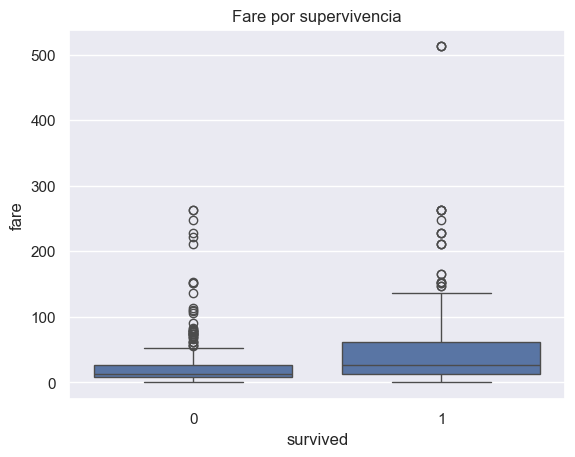

Guardado: figures\plot_count_sex_survived.png


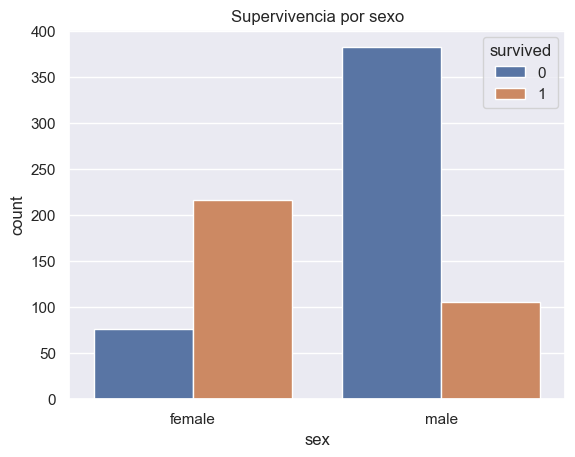

In [6]:
# === Celda 6: Bivariado (fare vs survived, sex vs survived) ===

if {"fare","survived"}.issubset(df.columns):
    plt.figure()
    sns.boxplot(x="survived", y="fare", data=df)
    plt.title("Fare por supervivencia")
    savefig("plot_box_fare_survived")
    plt.show()

if {"sex","survived"}.issubset(df.columns):
    plt.figure()
    sns.countplot(x="sex", hue="survived", data=df)
    plt.title("Supervivencia por sexo")
    savefig("plot_count_sex_survived")
    plt.show()




### plot_box_fare_survived.png
```bash
**Qu√© es:** Boxplot de tarifas por supervivencia
**Qu√© muestra:** Supervivientes pagaron tarifas M√ÅS ALTAS
**Insight:** La clase social influy√≥ en supervivencia
```

### plot_count_sex_survived.png
```bash
**Qu√© es:** Barras agrupadas de sexo vs supervivencia
**Qu√© muestra:** Mayor√≠a mujeres vivas, mayor√≠a hombres muertos
**Insight:** "Mujeres y ni√±os primero" se cumpli√≥
```

# FASE 4 An√°lisis profundo. Outliers:

# Celda 7: Matriz de Correlaci√≥n y outliers
Detecta usando m√©todo IQR Conserva outliers como leg√≠timos (ancianos, primera clase)

**- Matrices de correlaci√≥n**

La correlaci√≥n mide la relaci√≥n lineal entre dos variables num√©ricas y se expresa en valores entre -1 y 1:

    Coeficiente de correlaci√≥n de Pearson:
        Eval√∫a la relaci√≥n lineal entre dos variables continuas.
        Se calcula con df.corr(method='pearson') en pandas.

    Coeficiente de correlaci√≥n de Spearman:
        Se usa para relaciones mon√≥tonas (no necesariamente lineales).
        Se calcula con df.corr(method='spearman').

    Mapa de calor de correlaci√≥n
        Se utiliza seaborn.heatmap(df.corr(), annot=True, cmap='coolwarm') para visualizar correlaciones de m√∫ltiples variables.

**-	Comparaci√≥n entre Grupos**

Cuando se trabaja con datos categ√≥ricos y num√©ricos, es importante comparar los diferentes grupos para identificar diferencias significativas:

    Pruebas estad√≠sticas
        T-test: Compara la media de dos grupos para determinar si son significativamente diferentes.
        ANOVA: Eval√∫a diferencias entre m√°s de dos grupos.
        Chi-cuadrado: Determina si hay asociaci√≥n entre variables categ√≥ricas.

    Visualizaciones √∫tiles
        Boxplots y violin plots para comparar la distribuci√≥n entre grupos.
        Gr√°ficos de barras y conteo (seaborn.countplot()) para variables categ√≥ricas.


**-	An√°lisis de Outliers**

Los **outliers o valores at√≠picos** son observaciones que se desv√≠an significativamente del resto de los datos. Estos pueden deberse a errores en la recopilaci√≥n de datos, variabilidad natural o la presencia de eventos inusuales. Detectarlos y manejarlos adecuadamente es fundamental para mejorar la calidad del an√°lisis y la precisi√≥n de los modelos predictivos.

**- Detecci√≥n de Valores At√≠picos**

Antes de decidir c√≥mo tratar los outliers, es importante identificarlos correctamente. Algunas se√±ales de que un valor puede ser at√≠pico incluyen:

    Valores extremadamente altos o bajos en comparaci√≥n con la mayor√≠a de los datos.
    Impacto significativo en medidas estad√≠sticas como la media y la desviaci√≥n est√°ndar.
    Datos que no siguen la tendencia general observada en el conjunto de datos.

**-	M√©todos para Identificar Outliers**

Existen varias t√©cnicas estad√≠sticas y visuales para detectar valores at√≠picos: 

**‚Ä¢	M√©todos Estad√≠sticos**

    Rango intercuart√≠lico (IQR)
    Z-score (Puntaje Z)

**‚Ä¢	M√©todos Visuales**

    **‚Ä¢	Boxplots: Muestran los valores at√≠picos como puntos fuera del rango intercuart√≠lico.**
    **‚Ä¢	Gr√°ficos de dispersi√≥n (scatter plots): Permiten identificar valores que se desv√≠an del patr√≥n general.**
    **‚Ä¢	Histogramas y KDE plots: Ayudan a detectar distribuciones asim√©tricas o valores extremos.**


**-	Estrategias para Manejar Outliers**

Dependiendo del contexto y el impacto de los outliers en el an√°lisis, existen diversas estrategias para tratarlos:

    **‚Ä¢	Eliminaci√≥n de outliers**
        Se recomienda solo si hay evidencia clara de que el dato es err√≥neo o irrelevante.
        Puede aplicarse cuando los valores extremos afectan de manera significativa el an√°lisis.

    **‚Ä¢	Transformaci√≥n de datos**
        Uso de transformaciones como logaritmo (log), ra√≠z cuadrada (sqrt) o Box-Cox para reducir la influencia de valores extremos.

    **‚Ä¢	Imputaci√≥n de valores**
        Reemplazo de outliers con la media, mediana o valores interpolados.
        Uso de modelos predictivos para estimar valores razonables.

    **‚Ä¢	Tratamiento en modelos predictivos**
        Algunos algoritmos, como los √°rboles de decisi√≥n, son menos sensibles a outliers, mientras que otros, como la regresi√≥n lineal, pueden verse afectados significativamente.

El an√°lisis y tratamiento de outliers es clave para garantizar que los datos sean representativos y evitar distorsiones en las conclusiones. 


**- Transformaci√≥n de Variables**

La **transformaci√≥n de variables** es una etapa fundamental en el procesamiento de datos, ya que permite mejorar la interpretaci√≥n, el rendimiento de los modelos y la calidad del an√°lisis. Incluye t√©cnicas para escalar datos num√©ricos, convertir variables categ√≥ricas y crear nuevas caracter√≠sticas que enriquezcan el conjunto de datos.

**- Normalizaci√≥n de Datos**

La normalizaci√≥n es clave cuando los datos tienen escalas diferentes o valores extremos que pueden afectar el rendimiento de los modelos. Existen varios m√©todos:

    **‚Ä¢	Min-Max Scaling (Escalado Min-Max)**
    **‚Ä¢	Estandarizaci√≥n (Z-score Scaling)**
    **‚Ä¢	Transformaciones No Lineales**
    

**- Codificaci√≥n de Variables Categ√≥ricas**

Cuando las variables contienen valores de texto o categor√≠as, es necesario convertirlas a una representaci√≥n num√©rica para que los modelos puedan procesarlas.

    One-Hot Encoding (Codificaci√≥n One-Hot)
        Crea una columna binaria para cada categor√≠a.
        Se usa pd.get_dummies(df, columns=['columna']) en Pandas o OneHotEncoder() en Scikit-Learn.
        Aumenta la dimensionalidad del conjunto de datos.

    Label Encoding (Codificaci√≥n Ordinal)
        Asigna un n√∫mero entero a cada categor√≠a.
        Se usa LabelEncoder() en sklearn.preprocessing.
        Adecuado solo cuando hay un orden natural entre categor√≠as.

    Target Encoding (Codificaci√≥n basada en la variable objetivo)
        Reemplaza cada categor√≠a con la media de la variable objetivo.
        √ötil en problemas de clasificaci√≥n, pero puede causar sobreajuste.


**-	Creaci√≥n de Nuevas Caracter√≠sticas**

La ingenier√≠a de caracter√≠sticas puede mejorar significativamente el desempe√±o de los modelos. Algunas estrategias incluyen:

    **Combinaciones de variables**
        Crear nuevas variables a partir de la suma, resta, multiplicaci√≥n o divisi√≥n de otras.
        Ejemplo: Precio por metro cuadrado = precio_total / metros_cuadrados.

    **‚Ä¢	Extracci√≥n de informaci√≥n temporal**
        Extraer d√≠a de la semana, mes o hora de una fecha para detectar patrones temporales.

    **‚Ä¢	Agrupaci√≥n de valores**
        Convertir variables num√©ricas en rangos (binned features).
        Ejemplo: Categorizar edades en joven, adulto y mayor.

    **‚Ä¢	An√°lisis de texto**
        Extraer la longitud de textos o la frecuencia de palabras clave.

El an√°lisis de la relaci√≥n entre las variables predictoras y la variable objetivo es una etapa fundamental en cualquier proyecto de modelado. Permite identificar qu√© caracter√≠sticas tienen un mayor impacto en la predicci√≥n y ayuda a tomar decisiones informadas sobre la selecci√≥n de variables relevantes.

Una variable objetivo (tambi√©n conocida como variable dependiente, target variable, outcome variable o label) es la variable que se desea predecir o explicar en un an√°lisis de datos o en un modelo de machine learning. Es el punto central de cualquier modelo predictivo, ya que es la variable cuyo comportamiento o valor tratamos de entender o pronosticar a partir de otras variables (las variables predictoras o independientes).

**‚Ä¢	Importancia de Caracter√≠sticas**

Para entender qu√© variables influyen m√°s en la variable objetivo, se pueden aplicar varias t√©cnicas:

    **‚Ä¢	Correlaci√≥n (para variables num√©ricas)**
        Se usa el coeficiente de correlaci√≥n de Pearson para medir la relaci√≥n lineal entre una variable y la variable objetivo.
        Un valor cercano a 1 o -1 indica una fuerte relaci√≥n, mientras que un valor cercano a 0 sugiere una relaci√≥n d√©bil o nula.
        Se calcula con **df.corr()** en Pandas.

    **‚Ä¢	Importancia en modelos de Machine Learning**
    **‚Ä¢	√Årboles de decisi√≥n** y modelos basados en **RandomForest** permiten calcular la importancia de las caracter√≠sticas autom√°ticamente.
        Se obtiene con feature_importances_ en **sklearn.ensemble.RandomForestClassifier** o **RandomForestRegressor**.

    **‚Ä¢	Informaci√≥n mutua (para variables categ√≥ricas y mixtas)**
        Se basa en la teor√≠a de la informaci√≥n para medir cu√°nto conocimiento sobre la variable objetivo proporciona cada variable.
        Se implementa con mutual **info_classif** o **mutual_info_regression** en **Scikit-Learn**.


**‚Ä¢	Diferencias entre Grupos en la Variable Objetivo**

Si la variable objetivo es categ√≥rica (por ejemplo, en problemas de clasificaci√≥n), es √∫til comparar c√≥mo var√≠an las caracter√≠sticas entre diferentes clases:

    **‚Ä¢	An√°lisis de medias por categor√≠a**
    **‚Ä¢	Comparar la media de una variable num√©rica en funci√≥n de la clase de la variable objetivo.**
    **‚Ä¢	Se realiza con df.groupby('variable_objetivo').mean().**

    **‚Ä¢	Pruebas estad√≠sticas para detectar diferencias significativas**
    **‚Ä¢	Prueba t de Student (para comparar dos grupos).**
    **‚Ä¢	ANOVA (para comparar m√°s de dos grupos).**
    **‚Ä¢	Chi-cuadrado (para analizar asociaciones entre variables categ√≥ricas).**

Si la variable objetivo es num√©rica (en problemas de regresi√≥n), se pueden analizar patrones de variaci√≥n utilizando:

    **‚Ä¢	Diagramas de dispersi√≥n (scatter plots).**
    **‚Ä¢	Diagramas de cajas y bigotes (box plots).**
    **‚Ä¢	Regresiones lineales simples.**

**‚Ä¢	Selecci√≥n Preliminar de Caracter√≠sticas**

Una vez identificadas las relaciones con la variable objetivo, es posible reducir la dimensionalidad del conjunto de datos eliminando variables irrelevantes o redundantes. Algunas estrategias incluyen:

    **‚Ä¢	Eliminar variables con baja correlaci√≥n con la variable objetivo.**
    **‚Ä¢	Descartar variables con alta correlaci√≥n entre s√≠ (multicolinealidad), usando el Variance Inflation Factor (VIF).**
    **‚Ä¢	Utilizar t√©cnicas autom√°ticas de selecci√≥n de caracter√≠sticas, como SelectKBest o Recursive Feature Elimination (RFE) en Scikit-Learn.**

El an√°lisis de relaciones con la variable objetivo es crucial para construir modelos eficientes, evitando la inclusi√≥n de variables que pueden a√±adir ruido o sobreajustar el modelo. 


Guardado: figures\plot_corr_heatmap.png


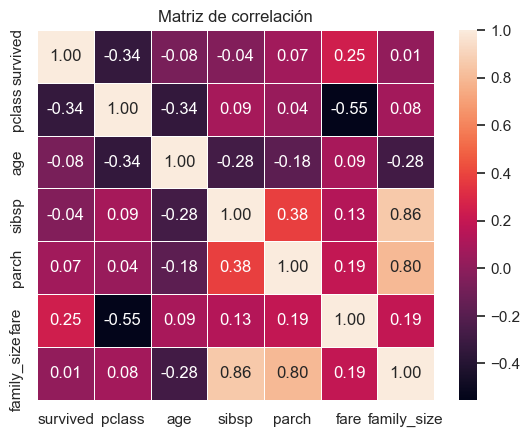

Outliers en age: 32 (l√≠mites: 0.38, 57.38)
Guardado: figures\plot_box_age.png


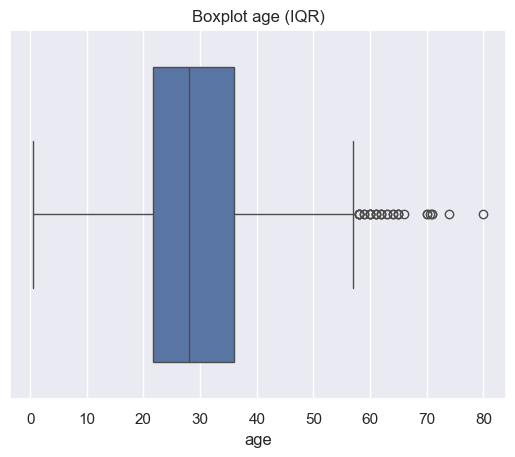

Outliers en fare: 97 (l√≠mites: -31.44, 73.86)
Guardado: figures\plot_box_fare.png


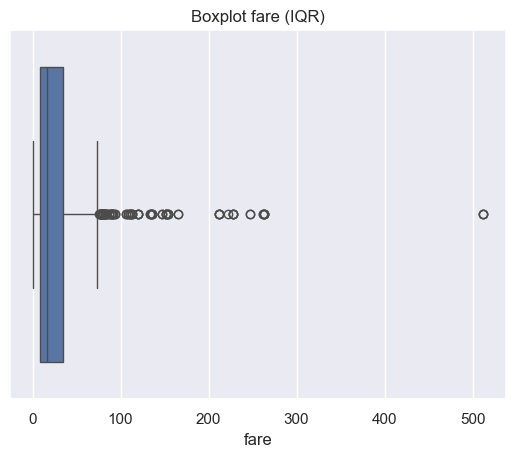

In [7]:
# Celda 7 ‚Äî Correlaci√≥n y outliers (IQR)
num_df = df.select_dtypes(include=[np.number])
corr = num_df.corr(numeric_only=True)

plt.figure()
ax = sns.heatmap(corr, annot=True, fmt=".2f", linewidths=.5)
ax.set_title("Matriz de correlaci√≥n")
savefig("plot_corr_heatmap")
plt.show()

def outlier_mask_iqr(series, k=1.5):
    q1, q3 = np.percentile(series.dropna(), [25, 75])
    iqr = q3 - q1
    low, high = q1 - k*iqr, q3 + k*iqr
    return (series < low) | (series > high), (low, high)

for col in ["age","fare"]:
    if col in df.columns:
        mask, (lo, hi) = outlier_mask_iqr(df[col])
        print(f"Outliers en {col}: {int(mask.sum())} (l√≠mites: {lo:.2f}, {hi:.2f})")
        plt.figure()
        sns.boxplot(x=df[col])
        plt.title(f"Boxplot {col} (IQR)")
        savefig(f"plot_box_{col}")
        plt.show()


### plot_corr_heatmap.png
```bash
**Qu√© es:** Matriz de correlaci√≥n entre variables num√©ricas
**Qu√© muestra:** Relaciones entre edad, tarifa, clase, familia, etc.
**Insight:** Identificar variables redundantes
```

### plot_box_age.png y plot_box_fare.png
```bash
**Qu√© son:** Boxplots para detecci√≥n de outliers
**Qu√© muestran:** Ancianos y tarifas altas como valores at√≠picos
**Insight:** Outliers leg√≠timos (no errores)
```

# Celda 8: Validaci√≥n estad√≠stica. Tests de hip√≥tesis:
T-test: Confirma que supervivientes pagaron m√°s (p < 0.05) Chi-cuadrado: Confirma asociaci√≥n sexo-supervivencia (p < 0.05)

In [8]:
# Celda 8 ‚Äî Tests de hip√≥tesis
if {"fare","survived"}.issubset(df.columns):
    g1 = df.loc[df["survived"]==1, "fare"].dropna()
    g0 = df.loc[df["survived"]==0, "fare"].dropna()
    t_stat, p_val = stats.ttest_ind(g1, g0, equal_var=False)
    print(f"T-test fare | survived: t={t_stat:.3f}, p={p_val:.3e}")

if {"sex","survived"}.issubset(df.columns):
    cont = pd.crosstab(df["sex"], df["survived"])
    chi2, p, dof, _ = stats.chi2_contingency(cont)
    print("Chi-cuadrado sex ~ survived:")
    display(cont)
    print(f"chi2={chi2:.3f}, dof={dof}, p={p:.3e}")
    # (opcional) guardar tabla de contingencia:
    save_table_image(cont, "tbl_contingency_sex_survived", title="Tabla contingencia sex~survived", round_ndigits=None)



T-test fare | survived: t=6.378, p=4.642e-10
Chi-cuadrado sex ~ survived:


survived    0    1
sex               
female     76  216
male      382  106

chi2=203.614, dof=1, p=3.397e-46
Tabla guardada: figures\tbl_contingency_sex_survived.png


# FASE 5 Conclusiones y preparaci√≥n:

## Celda 9 ‚Äî exportar CSVs limpios

## Resumen y Conclusiones

El **an√°lisis exploratorio de datos (EDA)** proporciona una comprensi√≥n profunda de las caracter√≠sticas de los datos y sus relaciones. Al final de este proceso, es fundamental sintetizar los hallazgos, identificar problemas y formular recomendaciones para los siguientes pasos en el an√°lisis o en la construcci√≥n de modelos. 

**Temas cubiertos:**

**- Hallazgos Principales**

El objetivo del resumen es destacar los hallazgos m√°s importantes y relevantes que surgieron del EDA. Estos hallazgos pueden incluir:

    **‚Ä¢	Distribuciones de las variables:** C√≥mo se distribuyen los datos (normal, sesgada, etc.).
    **‚Ä¢	Relaciones entre variables:** Identificaci√≥n de correlaciones significativas o relaciones entre variables predictoras y la variable objetivo.
    **‚Ä¢	Datos at√≠picos y valores faltantes:** Determinar si existen valores at√≠picos o si falta informaci√≥n importante en las variables.
    **‚Ä¢	Caracter√≠sticas importantes:** Variables que tienen un impacto significativo en la variable objetivo, basadas en an√°lisis estad√≠sticos o t√©cnicas de machine learning.

Un buen resumen debe proporcionar una visi√≥n clara de las caracter√≠sticas del conjunto de datos y c√≥mo estas caracter√≠sticas podr√≠an influir en el modelo.


**- Problemas Identificados**

Durante el EDA, es com√∫n encontrar problemas que podr√≠an afectar la calidad del an√°lisis o la precisi√≥n de los modelos. Algunos de los problemas m√°s comunes incluyen:

    **‚Ä¢	Valores faltantes:** Grandes cantidades de datos ausentes en algunas columnas que podr√≠an afectar el rendimiento del modelo.
    **‚Ä¢	Outliers:** Valores at√≠picos que pueden distorsionar las distribuciones y afectar la exactitud de los modelos predictivos.
    **‚Ä¢	Multicolinealidad:** Variables altamente correlacionadas entre s√≠, lo que puede causar problemas en modelos de regresi√≥n lineales o algoritmos sensibles a la multicolinealidad.
    **‚Ä¢	Distribuciones sesgadas:** Variables que no siguen una distribuci√≥n normal y que pueden requerir transformaciones para mejorar el an√°lisis.

Identificar estos problemas es crucial para decidir c√≥mo tratarlos antes de avanzar al modelado.


**- Recomendaciones para Pasos Siguientes**

Basado en los hallazgos y problemas identificados, se deben proponer recomendaciones claras para el an√°lisis posterior. Algunas recomendaciones comunes incluyen:

    **‚Ä¢	Manejo de valores faltantes:** Imputar valores faltantes o eliminar registros, dependiendo de la cantidad y la importancia de los datos faltantes.
    **‚Ä¢	Tratamiento de outliers:** Eliminar, transformar o manejar los outliers, dependiendo de su impacto en el an√°lisis.
    **‚Ä¢	Selecci√≥n de caracter√≠sticas:** Elegir las caracter√≠sticas m√°s relevantes basadas en su importancia para la variable objetivo, utilizando t√©cnicas como la selecci√≥n autom√°tica de caracter√≠sticas o la eliminaci√≥n manual de aquellas con baja correlaci√≥n.
    **‚Ä¢	Transformaciones de datos:** Normalizar o estandarizar variables cuando sea necesario para mejorar el rendimiento de ciertos modelos.
    **‚Ä¢	Pruebas de validaci√≥n:** Realizar validaciones cruzadas o pruebas adicionales para verificar la calidad del modelo antes de la implementaci√≥n.



In [9]:
# Celda 9 ‚Äî Exportar CSVs limpios
df_encoded = pd.get_dummies(df, drop_first=True)
df.to_csv("titanic_clean.csv", index=False)
df_encoded.to_csv("titanic_encoded.csv", index=False)
print("Guardados: titanic_clean.csv, titanic_encoded.csv")

Guardados: titanic_clean.csv, titanic_encoded.csv


üìã ARCHIVOS CSV (2 datasets procesados):

```bash
# 1. titanic_clean.csv

Qu√© es: Datos originales pero limpios
Contiene: Valores imputados, sin duplicados, tipos corregidos
Uso: Para an√°lisis posterior manteniendo interpretabilidad


# 2. titanic_encoded.csv

Qu√© es: Datos codificados para Machine Learning
Contiene: Variables categ√≥ricas convertidas a n√∫meros (one-hot encoding)
Uso: Listo para entrenar algoritmos de IA
```

üéØ INSIGHTS PRINCIPALES DESCUBIERTOS:

**Factor g√©nero es CR√çTICO** - Diferencia dram√°tica hombre vs mujer
**Clase social importa** - Tarifas altas = mayor supervivencia
**Protocolo mar√≠timo cumplido** - "Mujeres y ni√±os primero"
**Variables engineered √∫tiles** - family_size puede mejorar predicciones
**Datos de calidad** - Pocos problemas tras limpieza

Este script es un ejemplo perfecto de EDA profesional aplicando toda la teor√≠a que estudiamos. 